Saving IMDb Movies India.csv to IMDb Movies India (5).csv
Dataset Loaded Successfully!
First 5 rows:


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali



Dataset Shape: (15509, 10)

Columns:
 Index(['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director',
       'Actor 1', 'Actor 2', 'Actor 3'],
      dtype='object')

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB

Statistical Summary:


,Rating
count,7919.000000
mean,5.841621
std,1.381777
min,1.100000
25%,4.900000
50%,6.000000
75%,6.800000
max,10.000000



Missing Values Before Cleaning:
Name           0
Year         527
Duration    8264
Genre       1876
Rating      7584
Votes       7583
Director     524
Actor 1     1615
Actor 2     2381
Actor 3     3140
dtype: int64

Missing Values After Cleaning:
Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64


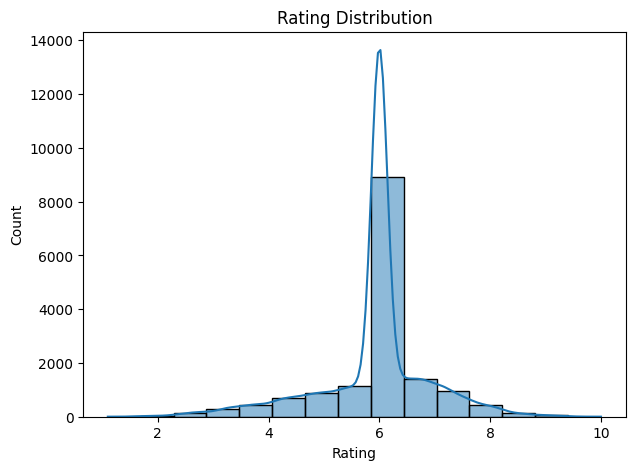

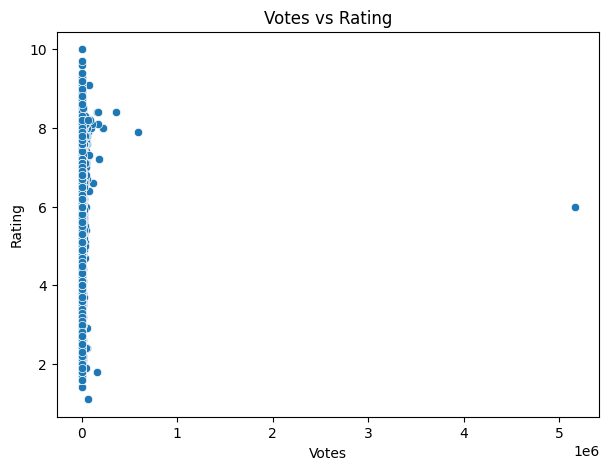

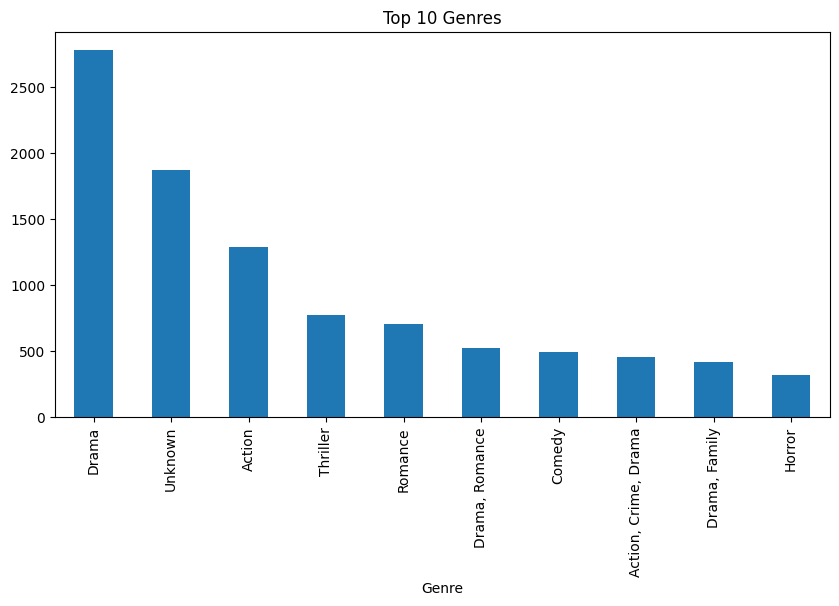


Training Data Shape: (12402, 5)
Testing Data Shape: (3101, 5)

Model Training Completed!

===== MODEL PERFORMANCE =====
Mean Absolute Error (MAE): 0.6396048511097967
Root Mean Squared Error (RMSE): 0.9647492480046749
R² Score: 0.047947204405048405

Predicted Rating for Sample Movie: 6.119846715519651


In [8]:
# ===============================================
# MOVIE RATING PREDICTION USING IMDB INDIA DATASET
# ===============================================

# STEP 1: IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# STEP 2: UPLOAD DATASET
from google.colab import files
uploaded = files.upload()

# Automatically read uploaded file
file_name = next(iter(uploaded.keys()))
df = pd.read_csv(file_name, encoding='latin1')

print("Dataset Loaded Successfully!")
print("First 5 rows:")
display(df.head())

# STEP 3: BASIC DATA EXPLORATION
print("\nDataset Shape:", df.shape)
print("\nColumns:\n", df.columns)
print("\nDataset Info:")
df.info()

print("\nStatistical Summary:")
display(df.describe())

# STEP 4: HANDLE MISSING VALUES AND CLEAN DATA TYPES

# Remove duplicate rows
df.drop_duplicates(inplace=True)

print("\nMissing Values Before Cleaning:")
print(df.isnull().sum())

# Clean 'Year' column: extract numeric year and convert to numeric
df['Year'] = df['Year'].str.extract(r'(\d{4})').astype(float)

# Clean 'Votes' column: remove non-numeric characters and convert to numeric
def clean_votes(votes_str):
    if pd.isna(votes_str) or votes_str == "Unknown": # Handle NaN and 'Unknown' string
        return np.nan
    s = str(votes_str).replace(',', '').replace('$', '').strip()
    if 'M' in s:
        try:
            return float(s.replace('M', '')) * 1_000_000
        except ValueError:
            return np.nan # If conversion after removing 'M' still fails
    if 'K' in s:
        try:
            return float(s.replace('K', '')) * 1_000
        except ValueError:
            return np.nan # If conversion after removing 'K' still fails
    try:
        return float(s)
    except ValueError:
        return np.nan # If direct conversion fails

df['Votes'] = df['Votes'].apply(clean_votes)

# Fill numeric missing values with median
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill categorical missing values with a placeholder
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].fillna("Unknown")

print("\nMissing Values After Cleaning:")
print(df.isnull().sum())

# STEP 5: VISUALIZATIONS

plt.figure(figsize=(7,5))
sns.histplot(df['Rating'], kde=True)
plt.title("Rating Distribution")
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='Votes', y='Rating')
plt.title("Votes vs Rating")
plt.show()

plt.figure(figsize=(10,5))
df['Genre'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Genres")
plt.show()

# STEP 6: FEATURE SELECTION
features = ['Genre', 'Director', 'Actor 1', 'Year', 'Votes']
target = 'Rating'

X = df[features]
y = df[target]

# Select categorical and numeric columns separately
categorical = ['Genre', 'Director', 'Actor 1']
numeric = ['Year', 'Votes']

# One Hot Encoding for categorical columns
preprocess = ColumnTransformer(
    [('encoder', OneHotEncoder(handle_unknown='ignore'), categorical)],
    remainder='passthrough'
)

# STEP 7: TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTraining Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

# STEP 8: BUILD & TRAIN MODEL
model = Pipeline([
    ('preprocessing', preprocess),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)
print("\nModel Training Completed!")

# STEP 9: MODEL EVALUATION
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n===== MODEL PERFORMANCE =====")
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

# STEP 10: SAMPLE PREDICTION
sample = pd.DataFrame({
    'Genre': ['Drama'],
    'Director': ['Sanjay Leela Bhansali'],
    'Actor 1': ['Ranveer Singh'],
    'Year': [2018],
    'Votes': [50000]
})

pred_rating = model.predict(sample)[0]
print("\nPredicted Rating for Sample Movie:", pred_rating)
